In [249]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression

import time

In [250]:
df_values = pd.read_csv('data/train_values.csv', index_col = 'building_id')
df_labels = pd.read_csv('data/train_labels.csv', index_col = 'building_id')

In [251]:
# This reduced our dataset by almost 33%!
selected_features = df_values.columns[:25]
features_list = []

for feature in selected_features:
    features_list.append(feature)
    
train_values_subset = df_values[features_list]

In [252]:
data_viz = train_values_subset.join(df_labels)

In [253]:
def damage_classifier(val):
    if val == 3:
        return 1
    else:
        return 0
data_viz['damage_grade'] = data_viz['damage_grade'].map(damage_classifier)

In [254]:
major_damage = data_viz

In [255]:
y = [25124, 148259, 87218]
x = ['Light Damage', 'Some Damage', 'Major Damage']

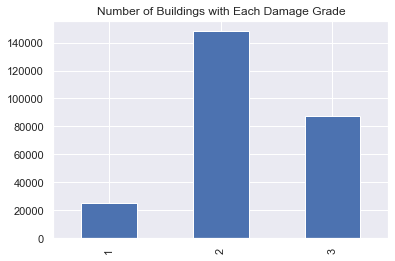

In [256]:
(df_labels.damage_grade
             .value_counts()
             .sort_index()
             .plot.bar(title="Number of Buildings with Each Damage Grade"));

In [257]:
data_viz.damage_grade.value_counts()

0    173383
1     87218
Name: damage_grade, dtype: int64

In [258]:
y = [25124, 148259, 87218]
x = ['Light Damage', 'Some Damage', 'Major Damage']

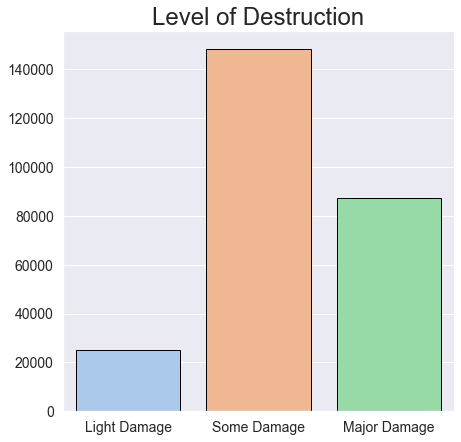

In [259]:
plt.figure(figsize=(7,7))
sns.barplot(x=x, y=y, edgecolor='black', palette='pastel')
plt.title('Level of Destruction', fontsize=24)
# plt.xlabel('', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [260]:
data_viz.damage_grade.value_counts(normalize = True)

0    0.66532
1    0.33468
Name: damage_grade, dtype: float64

In [261]:
major_damage.corr()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,damage_grade
geo_level_1_id,1.000000,-0.061405,0.002718,-0.089364,-0.003908,0.071158,-0.063474,-0.018245,-0.152038,0.007677,0.023656,-0.028854,0.134121,0.144985,0.074169,0.016454,0.015767,0.022670,-0.006878
geo_level_2_id,-0.061405,1.000000,0.000921,0.047730,0.012594,-0.049443,0.035516,0.015833,0.076491,-0.008743,-0.009122,0.014246,-0.079875,-0.023927,-0.032588,-0.038173,-0.036074,-0.020144,0.032129
geo_level_3_id,0.002718,0.000921,1.000000,-0.021646,-0.006385,-0.005643,-0.024507,-0.015732,0.026294,0.019579,0.005966,-0.023278,-0.005116,-0.003916,0.006143,0.002265,-0.012420,-0.010604,0.011411
count_floors_pre_eq,-0.089364,0.047730,-0.021646,1.000000,0.086668,0.101071,0.772734,0.174852,-0.027116,-0.041058,-0.011329,0.257279,-0.085821,-0.056637,-0.070487,0.007448,0.049000,-0.029888,0.077600
age,-0.003908,0.012594,-0.006385,0.086668,1.000000,-0.004323,0.061074,0.068032,0.001321,0.009129,-0.012128,0.079525,-0.036992,0.005855,-0.008374,-0.025431,-0.025552,-0.001520,0.012364
area_percentage,0.071158,-0.049443,-0.005643,0.101071,-0.004323,1.000000,0.196645,0.026287,-0.225541,-0.000473,0.073701,0.053362,0.210800,-0.053965,-0.031641,0.185047,0.224647,0.007928,-0.083373
height_percentage,-0.063474,0.035516,-0.024507,0.772734,0.061074,0.196645,1.000000,0.149725,-0.106573,-0.020260,0.012960,0.209098,0.001698,-0.052402,-0.063342,0.086228,0.129698,-0.019266,0.031836
has_superstructure_adobe_mud,-0.018245,0.015833,-0.015732,0.174852,0.068032,0.026287,0.149725,1.000000,-0.306861,0.006962,-0.014554,0.314979,-0.037549,0.011694,0.011528,-0.036830,-0.036782,0.057545,0.024993
has_superstructure_mud_mortar_stone,-0.152038,0.076491,0.026294,-0.027116,0.001321,-0.225541,-0.106573,-0.306861,1.000000,-0.034046,-0.104288,-0.376208,-0.470715,-0.040177,-0.054657,-0.222366,-0.224509,-0.041705,0.179471
has_superstructure_stone_flag,0.007677,-0.008743,0.019579,-0.041058,0.009129,-0.000473,-0.020260,0.006962,-0.034046,1.000000,0.037307,-0.033348,-0.043729,0.125311,0.078466,0.008448,-0.021406,0.065732,0.055229


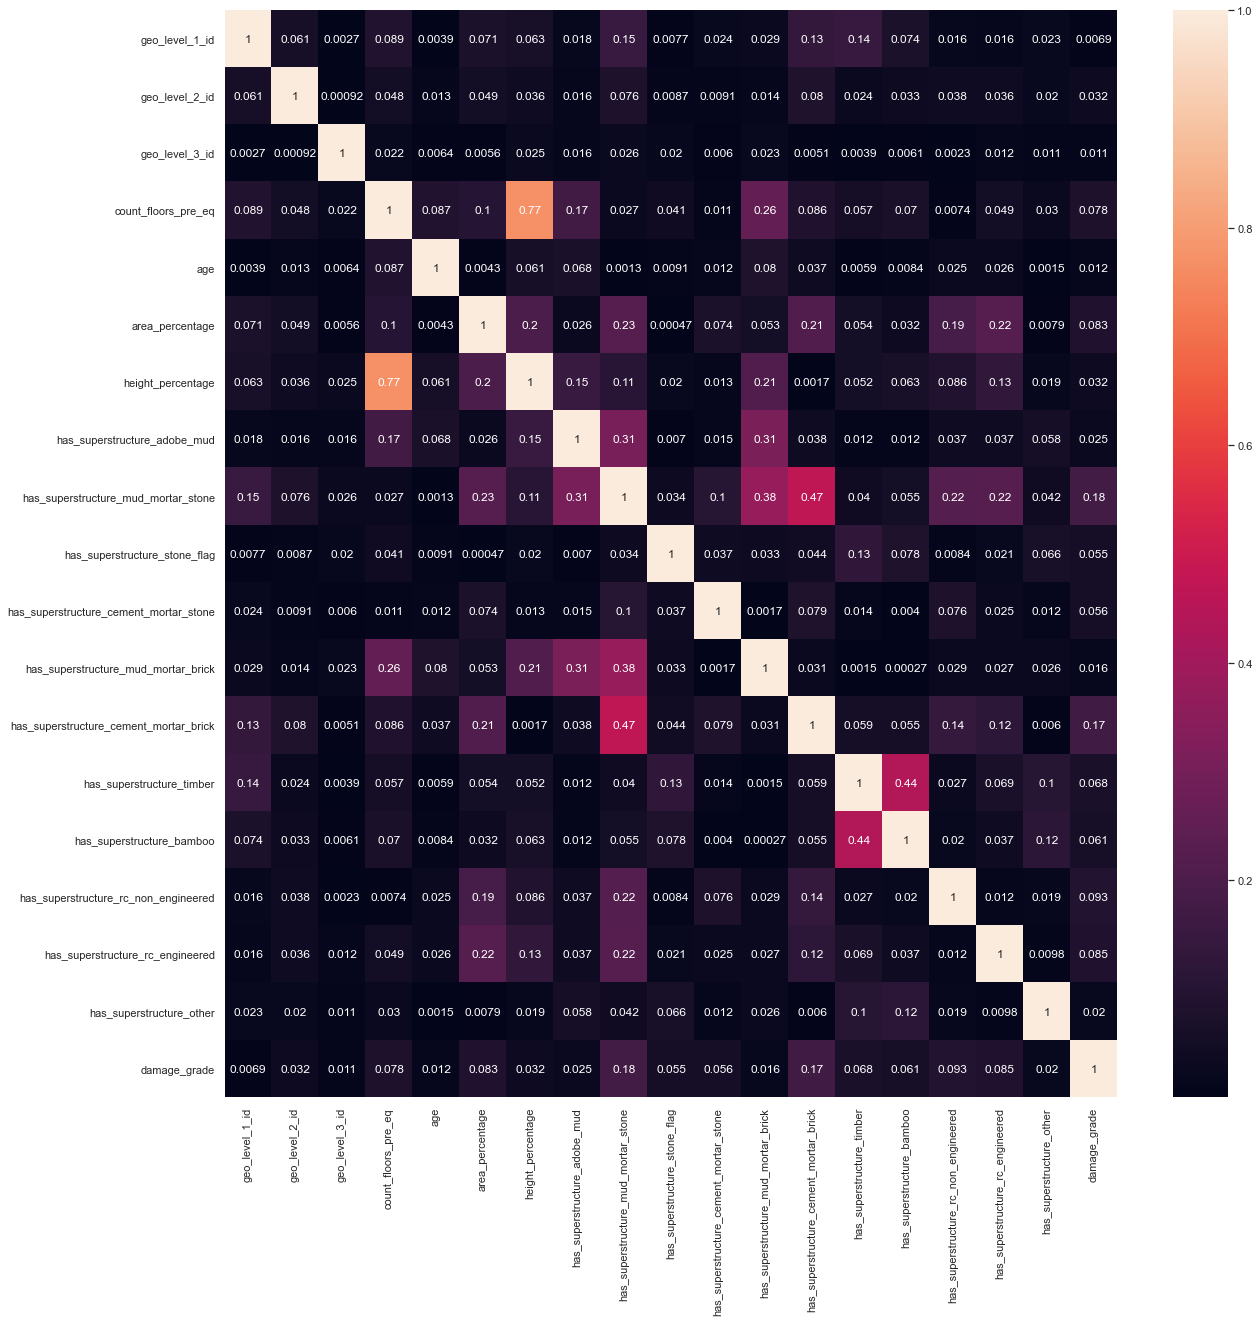

In [262]:
sns.set(rc={'figure.figsize':(20, 20)})
sns.heatmap(major_damage.corr().abs(),annot=True);

# Feature Importance

In [263]:
major_damage = major_damage.drop(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'position', 'plan_configuration'], axis = 1)

In [264]:
major_damage['foundation_type'].value_counts()


r    219196
w     15118
u     14260
i     10579
h      1448
Name: foundation_type, dtype: int64

In [265]:
# 1 = flat, 2 = Moderate, 3 = steep
def foundation(val):
    if val == 'r':
        return 1
    elif val == 'u':
        return 2
    elif val == 'w':
        return 3
    elif val == 'h':
        return 4
    elif val == 'i':
        return 5

major_damage['foundation_type'] = major_damage['foundation_type'].map(foundation)

In [266]:
major_damage['land_surface_condition'].value_counts()


t    216757
n     35528
o      8316
Name: land_surface_condition, dtype: int64

In [267]:
# 1 = flat, 2 = Moderate, 3 = steep
def land_type(val):
    if val == 't':
        return 1
    elif val == 'n':
        return 2
    else:
        return 3

major_damage['land_surface_condition'] = major_damage['land_surface_condition'].map(land_type)

In [268]:
major_damage['roof_type'].value_counts()


n    182842
q     61576
x     16183
Name: roof_type, dtype: int64

In [269]:
# q = Reinforced cement concrete slabs
# n = bamboo
# x = other
def roof(val):
    if val == 'n':
        return 1
    elif val == 'q':
        return 2
    else:
        return 3
major_damage['roof_type'] = major_damage['roof_type'].map(roof)

In [270]:
major_damage['ground_floor_type'].value_counts()

f    209619
x     24877
v     24593
z      1004
m       508
Name: ground_floor_type, dtype: int64

In [271]:
def floor_type(val):
    if val == 'f':
        return 1
    elif val == 'x':
        return 2
    elif val == 'v':
        return 3
    elif val == 'z':
        return 4
    elif val == 'm':
        return 5
major_damage['ground_floor_type'] = major_damage['ground_floor_type'].map(floor_type)

In [272]:
major_damage['other_floor_type'].value_counts()

q    165282
x     43448
j     39843
s     12028
Name: other_floor_type, dtype: int64

In [273]:
def floor_type_2(val):
    if val == 'q':
        return 1
    elif val == 'x':
        return 2
    elif val == 'j':
        return 3
    elif val == 's':
        return 4
major_damage['other_floor_type'] = major_damage['other_floor_type'].map(floor_type_2)

In [274]:
major_damage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 21 columns):
 #   Column                                  Non-Null Count   Dtype
---  ------                                  --------------   -----
 0   count_floors_pre_eq                     260601 non-null  int64
 1   age                                     260601 non-null  int64
 2   area_percentage                         260601 non-null  int64
 3   height_percentage                       260601 non-null  int64
 4   land_surface_condition                  260601 non-null  int64
 5   foundation_type                         260601 non-null  int64
 6   roof_type                               260601 non-null  int64
 7   ground_floor_type                       260601 non-null  int64
 8   other_floor_type                        260601 non-null  int64
 9   has_superstructure_adobe_mud            260601 non-null  int64
 10  has_superstructure_mud_mortar_stone     260601 non-null  int64


In [275]:
len(major_damage[major_damage['height_percentage'] > 11])

2434

In [276]:
major_damage = major_damage[major_damage['height_percentage'] < 11]

In [151]:
major_damage.to_csv('major_damage.csv')

### Train-Test split to use for feature selection

In [277]:
X_train, X_test, y_train, y_test = train_test_split(major_damage.drop('damage_grade', axis=1), major_damage['damage_grade'], test_size=0.25, random_state=1)

In [278]:
ss = StandardScaler()
ss.fit(X_train)

# Transform both Train and Test
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

#### Obtaining the most important features using Random Forest Classifier

In [279]:
feature_names = [f"feature {i}" for i in range(X_train_scaled.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=0)

In [280]:
start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.090 seconds


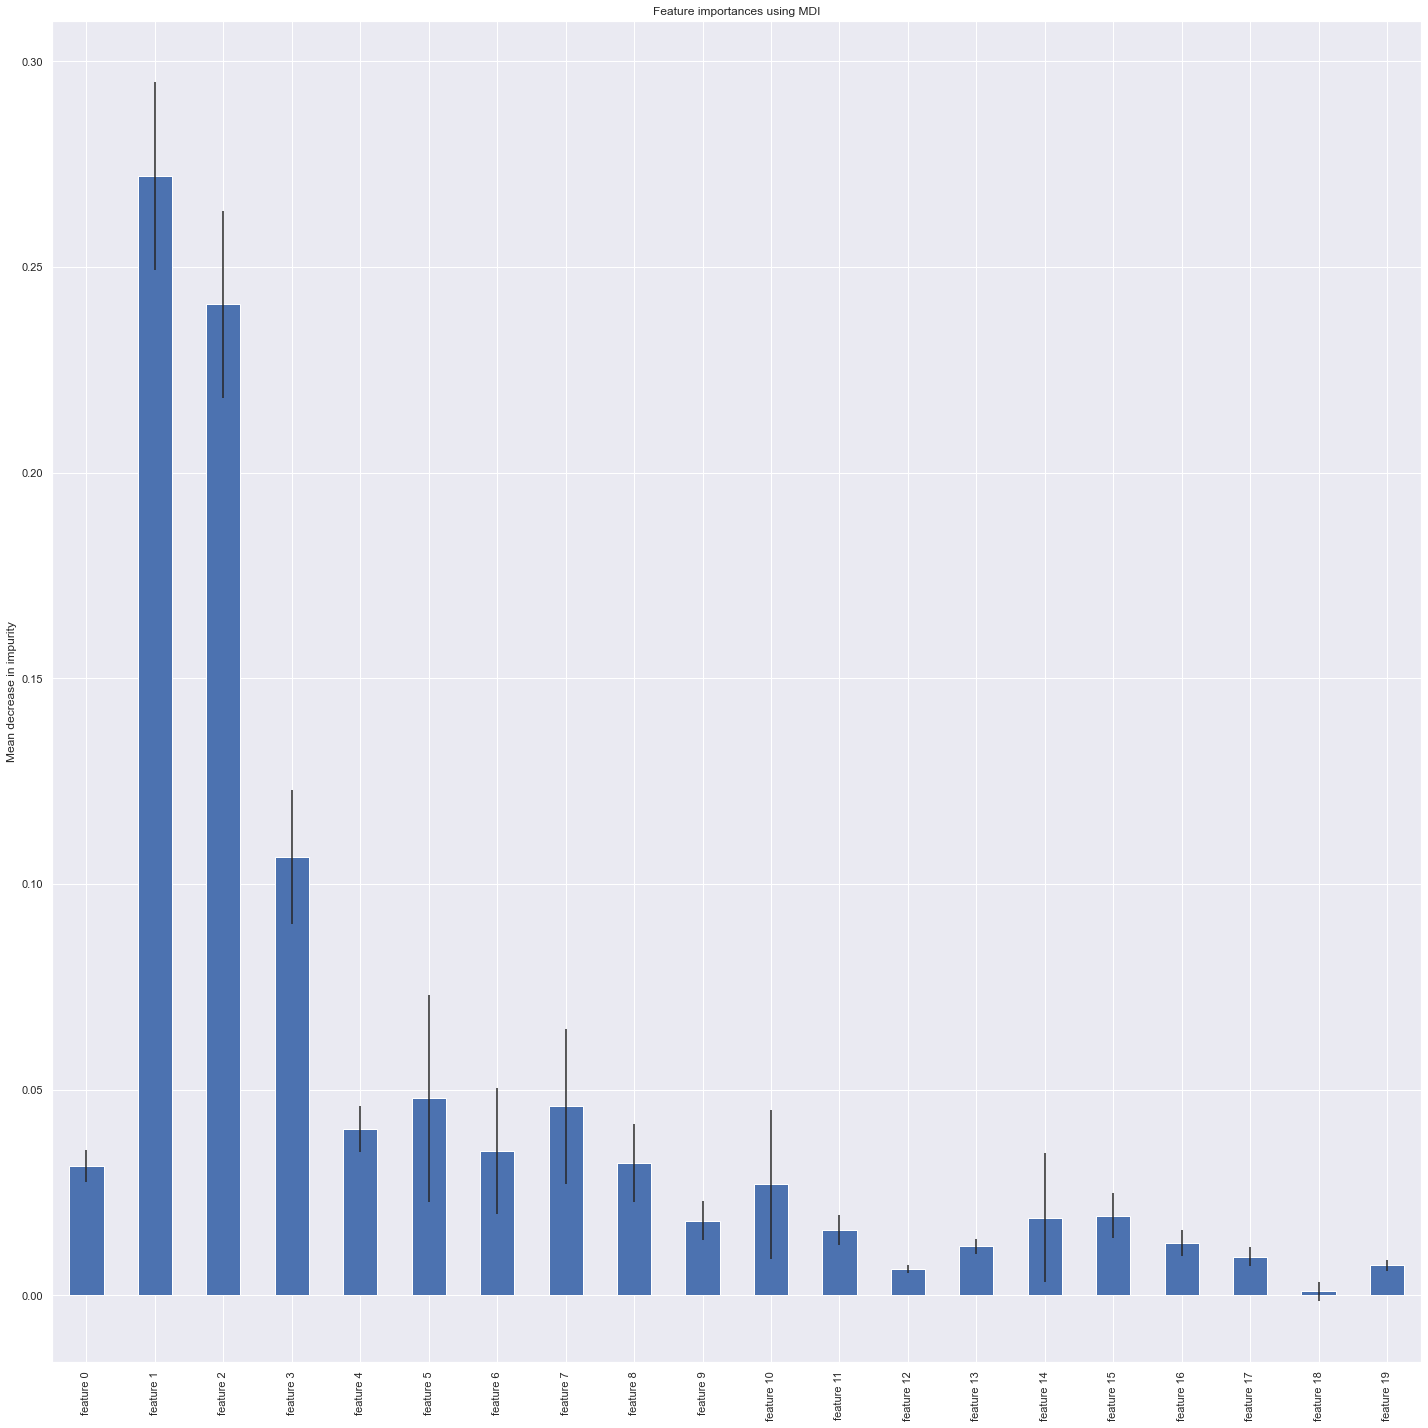

In [281]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Using Imputation to find most important features

In [282]:
start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 134.732 seconds


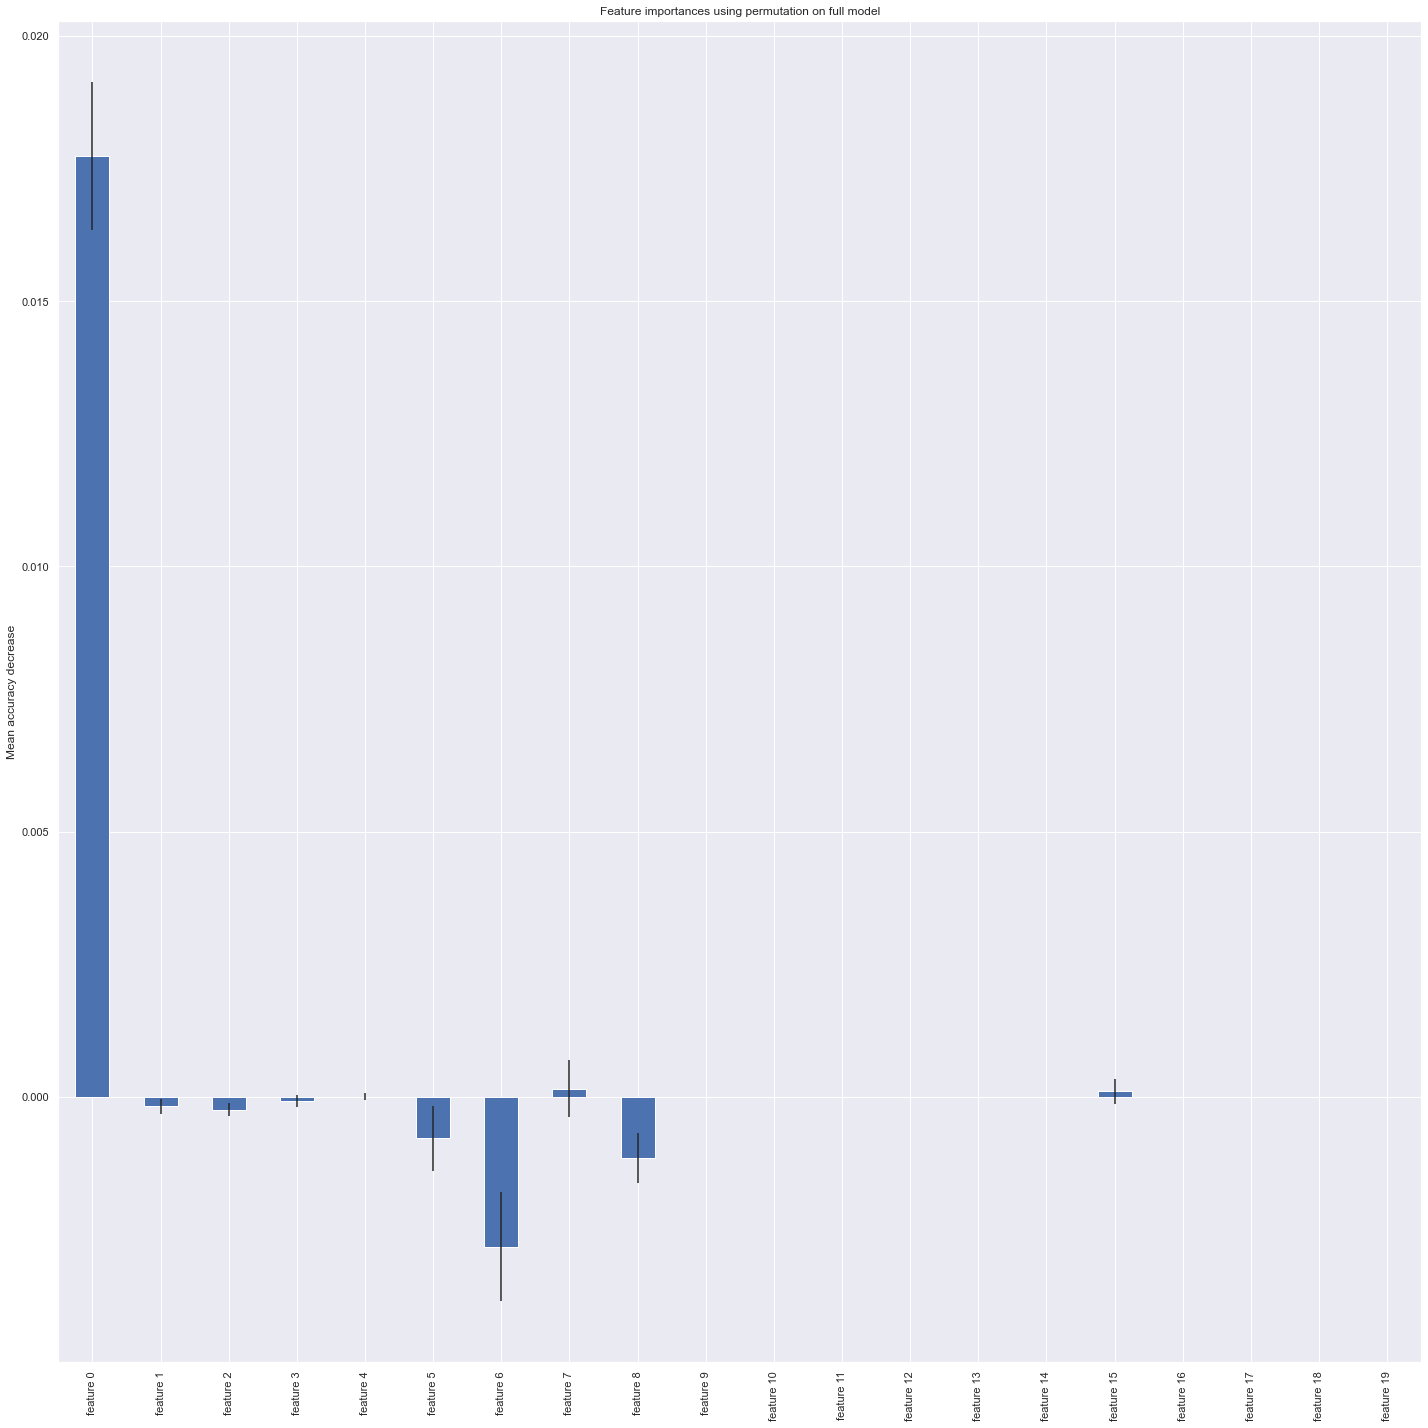

In [283]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Results were weird / difficult to comprehend, so we decided to use the first graph for explainability.

### Random Forest Determined Features ['Age', 'Area_percentage', 'Height_percentage'] as highest importance

# Using SelectKBest to Extract Important Features

In [284]:
X = major_damage.drop('damage_grade', axis = 1) 
y = major_damage['damage_grade'] 
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(5,'Score'))  #print 10 best features

                                     Specs        Score
1                                      age  8334.750501
14  has_superstructure_cement_mortar_brick  6682.519045
5                          foundation_type  6055.587226
2                          area_percentage  3728.420160
7                        ground_floor_type  2491.266452


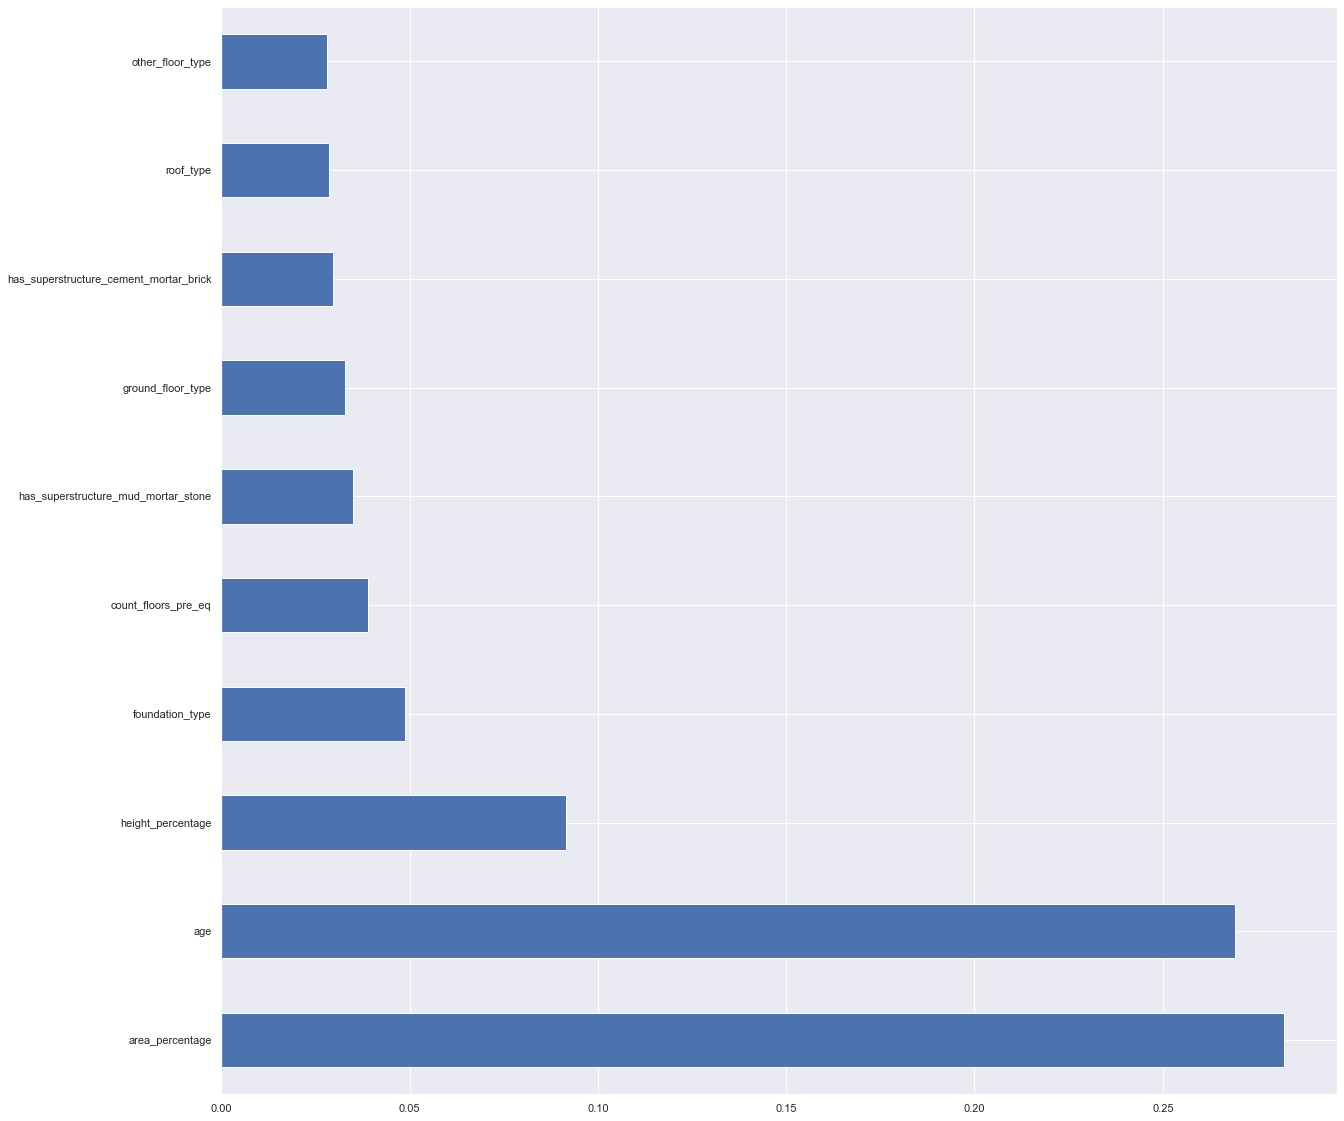

In [285]:
model = ExtraTreesClassifier()
model.fit(X,y)
#use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

### Extra Trees Classifier Determined Features ['Age', 'Area_percentage', Height_perentage'] as the most important features, similarily to the Random Forest Classifier

makes sense lol, Random Forest ~=~ Extra Trees

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Feature: 0, Score: 0.28250
Feature: 1, Score: -0.00029
Feature: 2, Score: -0.02306
Feature: 3, Score: -0.01535
Feature: 4, Score: -0.04971
Feature: 5, Score: -0.56507
Feature: 6, Score: 0.08812
Feature: 7, Score: -0.37068
Feature: 8, Score: 0.16406
Feature: 9, Score: 0.25324
Feature: 10, Score: 0.32675
Feature: 11, Score: 0.84137
Feature: 12, Score: -0.24066
Feature: 13, Score: -0.19650
Feature: 14, Score: -1.04513
Feature: 15, Score: -0.24484
Feature: 16, Score: -0.27296
Feature: 17, Score: -0.21668
Feature: 18, Score: -0.08915
Feature: 19, Score: -0.06422


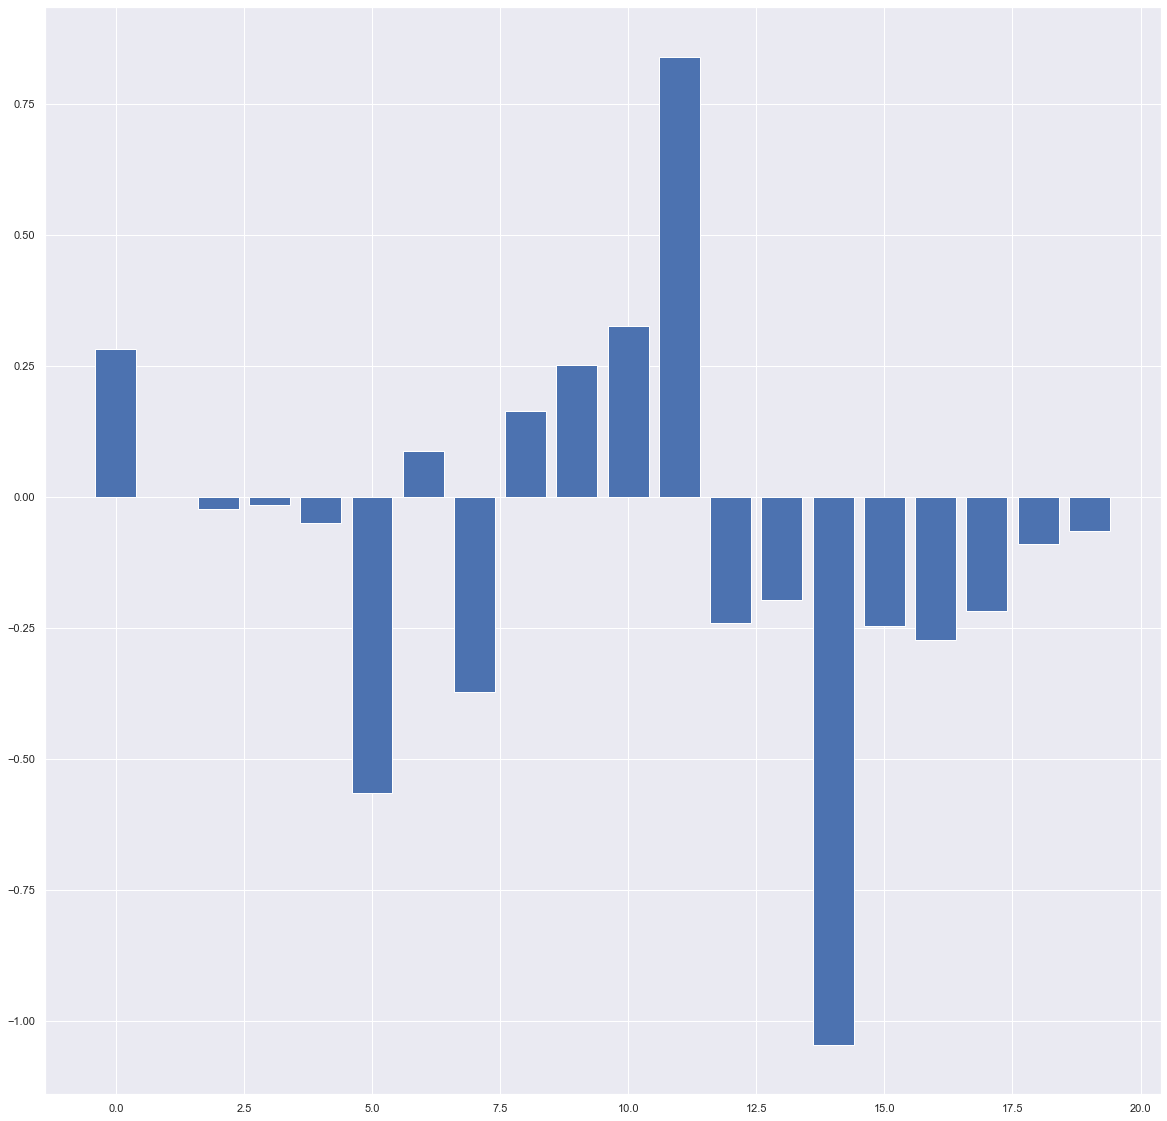

In [286]:
model = LogisticRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show();

### Features 11 and 14 have abnormally high and low scores, respectively. Feature 14, superstructure_cement_mortar_brick came up again from SelectKBest. Feature 11 was superstructure_stone_flag

In [287]:
major_damage['has_superstructure_cement_mortar_brick'].value_counts(normalize = True)

0    0.927615
1    0.072385
Name: has_superstructure_cement_mortar_brick, dtype: float64

In [288]:
major_damage['has_superstructure_stone_flag'].value_counts(normalize = True)

0    0.965629
1    0.034371
Name: has_superstructure_stone_flag, dtype: float64

### From this data, building's superstructure that were not made out of cement mortar - brick or stone, the building had a high likelyhood of being completely destroyed

In [315]:
major_damage['area_percentage'].value_counts()

6     41776
7     36450
5     32541
8     28234
9     21987
      ...  
82        1
62        1
55        1
90        1
96        1
Name: area_percentage, Length: 83, dtype: int64

In [316]:
small_houses = major_damage[major_damage['area_percentage'] < 10]
big_houses = major_damage[major_damage['area_percentage'] > 10]

In [319]:
len(small_houses)

194899

In [318]:
len(big_houses)

46922